# Predicting the next word in a Shakesparean sonnet dataset

In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

For this assignment you will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [2]:
#downloading the shakespearean sonnets dataset
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 134MB/s]


In [3]:

# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

#displaying the first five sentences in the dataset
print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


In [4]:
#Instantiating the tokenizer class in tensorflow
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:
corpus[0]

'from fairest creatures we desire increase,'

If you pass this text directly into the `texts_to_sequences` method you will get an unexpected result:

In [6]:
#converting the corpus into sequences of integers
tokenizer.texts_to_sequences(corpus)

[[34, 417, 877, 166, 213, 517],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311, 635, 102, 200, 25, 278],
 [16, 10, 880, 3, 62, 85, 214, 53],
 [1372, 9, 1373, 636, 11, 122, 1374, 1375],
 [201, 17, 1376, 64, 518, 202],
 [118, 9, 1377, 3, 9, 47, 122, 135, 279],
 [10, 8, 54, 63, 2, 418, 312, 419],
 [1, 352, 1378, 3, 2, 1379, 420],
 [215, 62, 85, 881, 1380, 9, 882],
 [1, 311, 883, 884, 313, 7, 1381],
 [257, 2, 94, 36, 353, 29, 1382, 21],
 [3, 637, 2, 418, 354, 30, 2, 638, 1, 19],
 [27, 1383, 885, 46, 1384, 9, 280],
 [1, 1385, 281, 1386, 7, 9, 134, 1387],
 [9, 1388, 179, 1389, 20, 1390, 35, 63],
 [49, 21, 17, 886, 639, 4, 887, 126, 888],
 [38, 81, 1391, 64, 23, 9, 51, 202],
 [64, 23, 2, 258, 4, 9, 889, 145],
 [3, 95, 215, 62, 85, 281, 1392, 53],
 [86, 146, 23, 1393, 236, 1, 1394, 96],
 [71, 136, 43, 96, 1395, 9, 134, 186],
 [42, 10, 1396, 640, 890, 69, 282, 4, 44],
 [46, 519, 5, 520, 1, 65, 5, 112, 314, 147],
 [1397, 25, 51, 30, 1398, 62],
 [29, 86, 3, 21, 

This happened because `texts_to_sequences` expects a list and you are providing a string. However a string is still and `iterable` in Python so you will get the word index of every character in the string.

Instead you need to place the example whithin a list before passing it to the method:

Notice that you received the sequence wrapped inside a list so in order to get only the desired sequence you need to explicitly get the first item in the list like this:

In [7]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

In [8]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(token_list)):
        n_gram_sequences = token_list[:i+1]
        input_sequences.append(n_gram_sequences)

    return input_sequences

In [9]:
# grader-required-cell

# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [10]:
# grader-required-cell

# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

In [11]:

# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences:

In [12]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')
    return padded_sequences

In [13]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [14]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

**Expected Output:**

```
array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)
```

In [15]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Splitting the data into features and labels sets


Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.




In [16]:

def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [17]:
# grader-required-cell

# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [18]:

# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Building the model
### Creating the model using Bidirectional LSTM to enable bidirectional-flow of inputs into the layers, which results in improved performance of the model on sequential data

In [19]:
def create_model(total_words, max_sequence_len):

    import tensorflow as tf
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(total_words)))
    model.add(Dense(total_words, activation='softmax'))


    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])


    return model

In [20]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 72s 132ms/step - loss: 8.2425 - accuracy: 0.0193
Epoch 2/50
484/484 [==============================] - 57s 118ms/step - loss: 8.6621 - accuracy: 0.0159
Epoch 3/50
484/484 [==============================] - 57s 117ms/step - loss: 7.9864 - accuracy: 0.0195
Epoch 4/50
484/484 [==============================] - 57s 117ms/step - loss: 7.5540 - accuracy: 0.0295
Epoch 5/50
484/484 [==============================] - 57s 117ms/step - loss: 7.1965 - accuracy: 0.0398
Epoch 6/50
484/484 [==============================] - 57s 117ms/step - loss: 6.7376 - accuracy: 0.0463
Epoch 7/50
484/484 [==============================] - 56s 117ms/step - loss: 5.7294 - accuracy: 0.0644
Epoch 8/50
484/484 [==============================] - 57s 117ms/step - loss: 5.1203 - accuracy: 0.0823
Epoch 9/50
484/484 [==============================] - 57s 118ms/step - loss: 4.8002 - accuracy: 0.0940
Epoch 10/50
484/484 [==============================] - 57s 118ms/step - l

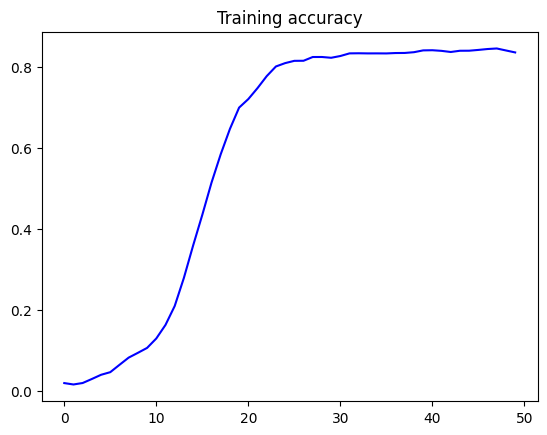

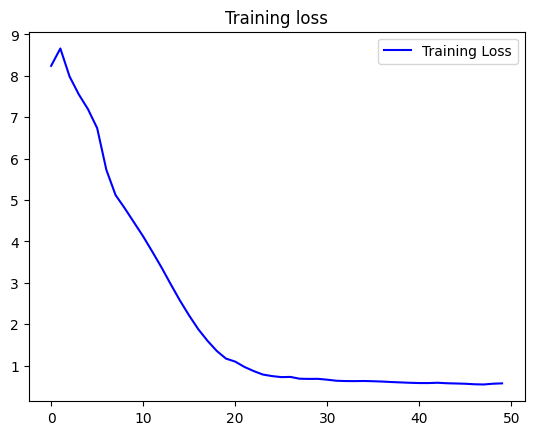

In [21]:
'''A visualization curve depicting the graphical illustration of the model's epochs (training time)
 against its accuracy and accuracy loss.'''
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [22]:
#saving the model
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
#Testing the predictive performance of the model to complete a text in the Shakespearean dataset.
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope thy love's loving parts of thee lie hid in thee ' ' doth grow and thee doth love me more than i love her in my verse ever live and loving are lie new to go dear friend ' ' are mute part her me ' are doth grow can none express'd free thou lovest thee so thine blind ward can none ' light seen thee more ' ' thine in me ' doth i fear thee dear love ' me quite bright to youth me be me more strong thy will eyes me so thy show hue youth me
